(100, 1)


/Users/patricfulop/anaconda3/envs/edward_tensorflow/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: -27.166


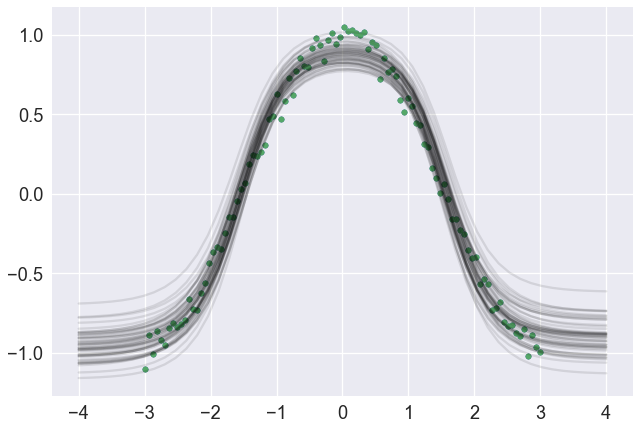

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
from edward.models import Bernoulli, Empirical, Beta, Uniform, Normal
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.animation import FuncAnimation
from tempfile import NamedTemporaryFile
from IPython.display import HTML
import seaborn as sns
import numpy as np
import six
import tensorflow as tf

plt.style.use('seaborn-talk')
sns.set_context("talk", font_scale=1.4)
# sns.set_palette("colorblind")
sess = ed.get_session()

#sns.palplot(sns.color_palette())

# Move the plotting, evaluating and building dummy datasets functions in a helper class 
def plot_pdf(pdf):
    x = tf.range(0.0, 1.0, 0.001)
    plt.plot(*sess.run([x, pdf.prob(x)]));

def scatter_plot(x,y, dot_size):    
    plt.scatter(x, y, s=dot_size);
    
def build_dataset(N,D):
    x = tf.linspace(-3.0, 3.0, num=N)
    y = Normal(loc = tf.cos(x), scale = tf.ones(N)* 0.05)
    return sess.run([tf.reshape(x,[N,D]), tf.reshape(y,[N,D])])    

def neural_network(x, W_0, W_1, W_2, b_0, b_1, b_2):
    h1 = tf.sigmoid(tf.matmul(x, W_0) + b_0)
    h2 = tf.sigmoid(tf.matmul(h1,W_1)+b_1)
    h = tf.matmul(h2,W_2)+b_2
    return h

# TRAINING DATA
N = 100
D = 1 
dim = 2 # dim = 2 units per layer
x_train, y_train = build_dataset(N,D)
scatter_plot(x_train,y_train, 30)

#x_train = x_train.astype(np.float32).reshape((N, D))
#y_train = y_train.astype(np.float32).reshape((N, D))

# 3 layer MODEL - here we are just approximating a noisy cosine function
W_0 = Normal(loc=tf.zeros([D, dim]), scale=tf.ones([D, dim])) # Weights & Biases, normally distributed (prior)
W_1 = Normal(loc=tf.zeros([dim, dim]), scale=tf.ones([dim, dim]))
W_2 = Normal(loc=tf.zeros([dim, D]), scale=tf.ones([dim, D]))

b_0 = Normal(loc=tf.zeros(dim), scale=tf.ones(dim))
b_1 = Normal(loc=tf.zeros(dim), scale=tf.ones(dim))
b_2 = Normal(loc=tf.zeros(D), scale=tf.ones(D))

# Create the NN 
x = tf.placeholder(tf.float32, [N, D])
y = Normal(loc=neural_network(x,W_0,W_1,W_2,b_0,b_1,b_2), 
           scale=0.1*tf.ones(D))
print(y.shape)
#y = tf.reshape(y,[N,D])

# INFERENCE the KL way 
qW_0 = Normal(loc=tf.Variable(tf.random_normal([D, dim])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, dim]))))
qW_1 = Normal(loc=tf.Variable(tf.random_normal([dim, dim])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([dim, dim]))))
qW_2 = Normal(loc=tf.Variable(tf.random_normal([dim, D])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([dim, D]))))
qb_0 = Normal(loc=tf.Variable(tf.random_normal([dim])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([dim]))))
qb_1 = Normal(loc=tf.Variable(tf.random_normal([dim])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([dim]))))
qb_2 = Normal(loc=tf.Variable(tf.random_normal([D])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))

inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1,
                     W_2: qW_2, b_2: qb_2}, data={x: x_train, y: y_train})
inference.run()

# CRITICIZE by drawing samples
scatter_plot(x_train,y_train, 30);

xs = tf.placeholder(tf.float32, [50, D])
[plt.plot(np.linspace(-4.0, 4.0, 50),
          sess.run(neural_network(xs,qW_0,qW_1,qW_2,qb_0,qb_1,qb_2),
                   {xs: np.linspace(-4.0, 4.0, 50)[:, np.newaxis]}),
          color='black', alpha=0.1)
 for _ in range(50)];

